<a href="https://colab.research.google.com/github/dnguchu/Sentiment-Analysis/blob/eric/Copy_of_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#importing data via the link
import kagglehub
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.


In [ ]:
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [ ]:
#convert into dataframe
df=pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
!pip install nltk

In [ ]:
#Data preprocessing using natural language toolkit
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


In [ ]:
def preprocess_text(text):
    # Remove punctuation and lowercase
    import re
    text = re.sub(r'[^\w\s]', '', text).lower()
    # Tokenize and remove stop words
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing
df['cleaned_review'] = df['review'].apply(preprocess_text)


In [ ]:
df.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching 1 oz episode y...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [ ]:
#check whether class imbalance exists
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [ ]:
#dataset is fairly balanced
#now for proportions
df['sentiment'].value_counts(normalize=True)


,proportion
sentiment,
positive,0.5
negative,0.5


In [ ]:
#Encode the labels with a numerical value
import sklearn
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['sentiment']=le.fit_transform(df['sentiment'])
le.classes_

array(['negative', 'positive'], dtype=object)

In [ ]:
df['sentiment']

,sentiment
0,1
1,1
2,1
3,0
4,1
...,...
49995,1
49996,0
49997,0
49998,0


In [ ]:
#let us use class weighting in case there happens to be an imbalance in a hypothetical situation
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(df['sentiment'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=df['sentiment']
)

class_weight_dict = dict(zip(classes, class_weights))
class_weight_dict


{np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0)}

In [ ]:
#train/test split with weighted data
from sklearn.model_selection import train_test_split

X = df['cleaned_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
#note: stratify tells train_test_split to preserve the class distribution of y in both the train set and test set

In [ ]:
#Vectorising the data and implementing a ML pipeline
#multinomial naive bayes is designed for count-based features and works with both vectorisers
#alpha controls laplace smoothing

In [ ]:
#define a reusable pipeline that lets us swap vectorisers and tune hyperparameters cleanly
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


**Experiment configurations (feature engineering)**

We’ll test:
* Count vs TF-IDF
* Unigrams vs Bigrams
* Different min_df
* Different alpha

In [ ]:
#CountVectorizer + Multinomial Naive Bayes
pipeline_count = Pipeline([
    ('vectorizer', CountVectorizer(
        min_df=5,
        max_features=20000,
        ngram_range=(1,2)
    )),
    ('clf', MultinomialNB(alpha=0.5))
])


In [ ]:
#Hyperparameter grid
param_grid_count = {
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__min_df': [5],        # remove min_df=1
    'clf__alpha': [0.5, 1.0]
}



In [ ]:
#TF-IDF vectoriser with naive Bayes
pipeline_count = Pipeline([
    ('vectorizer', CountVectorizer(max_features=20000)),
    ('clf', MultinomialNB())
])



In [ ]:
#cross validation and alpha tuning
from sklearn.model_selection import GridSearchCV


In [ ]:
#CountVectoriser Search
grid_count = GridSearchCV(
    pipeline_count,
    param_grid_count,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid_count.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(max_features=20000)),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.5, 1.0], 'vectorizer__min_df': [5],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

Grid search with cross-validation selected a pipeline consisting of a CountVectorizer with unigram and bigram features, a minimum document frequency of 5, and a maximum vocabulary size of 20,000, followed by a Multinomial Naive Bayes classifier with smoothing parameter α = 0.5.

Ok so it is VERY important to make sure that the cross-validation is not computationally expensive. To optimise for speed for later cases, it's best to use random search since it will find good answers early.

When using Grid search it's best to use low values of cv and to just reduce the number of models trained


In [ ]:
#Do the same for TF-IDF Search
#TF_IDF vectoriser with multinomial naive bayes
pipeline_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [ ]:
#Hyperparameter grid
param_grid_tfidf = {
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__min_df': [5],
    'vectorizer__max_df': [0.9],
    'vectorizer__max_features': [20000],
    'clf__alpha': [0.5, 1.0]
}


In [ ]:
# TF-IDF Grid Search
grid_tfidf = GridSearchCV(
    pipeline_tfidf,
    param_grid_tfidf,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid_tfidf.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.5, 1.0], 'vectorizer__max_df': [0.9],
                         'vectorizer__max_features': [20000],
                         'vectorizer__min_df': [5],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [ ]:
#check results of TF-IDF vectoriser
grid_tfidf.best_params_
grid_tfidf.best_score_


np.float64(0.8713749492154883)

In [ ]:
#compare with CountVectoriser
grid_count.best_score_



np.float64(0.8646999323325666)

Here we see a marginally small difference between both vectorisation methods. However the TF-IDF vectoriser is the one which performed better.


In [ ]:
# Model Evaluations
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
best_count_model = grid_count.best_estimator_

y_pred_count = best_count_model.predict(X_test)

print("CountVectorizer Test Accuracy:",
      accuracy_score(y_test, y_pred_count))

print(classification_report(y_test, y_pred_count))



CountVectorizer Test Accuracy: 0.8662
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      5000
           1       0.86      0.87      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
best_count_model = grid_tfidf.best_estimator_

y_pred_count = best_count_model.predict(X_test)

print("TF-IDF Vectoriser Test Accuracy:",
      accuracy_score(y_test, y_pred_count))

print(classification_report(y_test, y_pred_count))


TF-IDF Vectoriser Test Accuracy: 0.8753
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      5000
           1       0.86      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
#Compute the confusion matrix for intuitiveness and interpretation
best_tfidf = grid_tfidf.best_estimator_
y_pred = best_tfidf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm



array([[4291,  709],
       [ 538, 4462]])

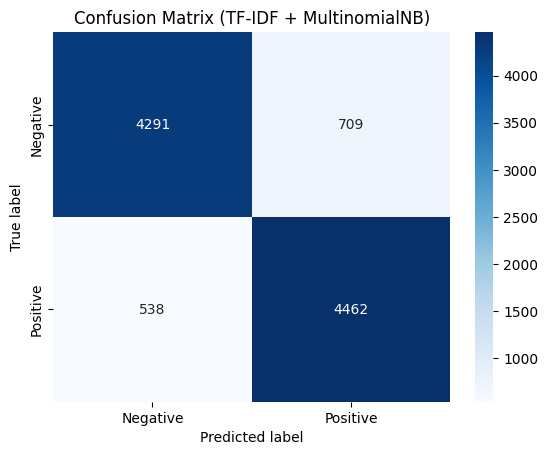

In [ ]:
#use matplotlib for better clarity
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negative', 'Positive'],
    yticklabels=['Negative', 'Positive']
)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (TF-IDF + MultinomialNB)')
plt.show()

In [ ]:
cm_norm = confusion_matrix(
    y_test,
    y_pred,
    normalize='true'
)
cm_norm

array([[0.8582, 0.1418],
       [0.1076, 0.8924]])

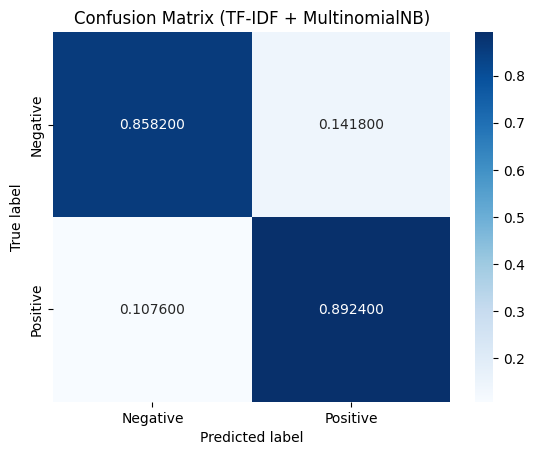

In [ ]:
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='f',
    cmap='Blues',
    xticklabels=['Negative', 'Positive'],
    yticklabels=['Negative', 'Positive']
)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (TF-IDF + MultinomialNB)')
plt.show()